<a href="https://colab.research.google.com/github/AchrafAsh/gnn-receptive-fields/blob/main/05_measuring_problem_radius.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Hardware specs**

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Aug  4 13:55:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


## **🚀 Setting up the environment**

In [1]:
import os, sys
import os.path as osp
from google.colab import drive, files
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
try:
    os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
except:
    pass
sys.path.insert(0, nb_path)  # or append(nb_path)

Mounted at /content/mnt


In [2]:
import time
import concurrent.futures
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch

from collections import Counter
from torch_geometric.utils import to_dense_adj
from tqdm.notebook import tqdm

%matplotlib inline
sns.set_theme(font_scale=1.8)
sns.set_style("white")

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

## **🧰 Utility functions**

In [3]:
def hop_neighbors(k:int, dense_adj: torch.Tensor):
    cum_neighbors = pow_A = dense_adj.clone()

    yield dense_adj, dense_adj

    for _ in range(k-1):
        pow_A = torch.mm(dense_adj, pow_A)
        neighbors = torch.where(
            (torch.clamp(pow_A, max=1, min=0) - cum_neighbors) > 0,
            1, 0)
        cum_neighbors += neighbors
        
        yield neighbors, cum_neighbors

In [4]:
def scale(X:torch.Tensor):   
    m = X.mean(0)
    s = X.std(0)
    ones = torch.ones(s.shape).to(device)
    s = torch.where(s == 0, ones, s)
    return (X - m)/ s

In [5]:
def centroids(X:torch.Tensor, y:torch.Tensor):
    """Returns the label representation by averaging its nodes' features

    Args:
        - X [num_nodes, num_features]: node features
        - y [num_nodes]: labels
    """
    num_classes = y.max().item() + 1
    
    # group nodes by label
    obs = {}
    for i in range(X.size(0)):
        if obs.get(y[i].item()):
            obs[y[i].item()] += [X[i]]
        else:
            obs[y[i].item()] = [X[i]]

    return torch.stack([sum(obs[c]) / len(obs[c]) for c in range(num_classes)], 0)

In [6]:
def homophily_index(y:torch.Tensor, neb:torch.tensor, mask=None, optim='memory'):
    """Computes the homophily index
    Args:
        - y [num_nodes]: labels of all nodes
        - neb [num_nodes, num_nodes]: neighbors to consider (can be the adjacency matrix or k-hop neighborhood)
        - mask [num_nodes]: "train", "test" or "val" to consider only these specific neighbors
    """
    num_nodes = y.size(0)

    if mask == None:
        mask = torch.ones(num_nodes).to(device)

    if(optim == 'memory'):
        return torch.stack([(y[neb[i] * mask == 1] == y[i]).float().mean() if (neb[i] * mask == 1).sum() > 0 else torch.tensor(0.).to(device) for i in range(num_nodes)], 0)

    if(optim == 'gpu'):
        masked_neb = neb * mask.to(device)
        yy = y.unsqueeze(1).expand(-1, num_nodes).to(device)

        return (((masked_neb.long() * yy.t()) == yy ) * (masked_neb == 1)).sum(1) / ((masked_neb == 1).sum(1) + 1e-8)

In [7]:
def corr(x, y, i):
    if x.size(0) == 0: return torch.tensor(0., device=device)
    cov = torch.einsum('ij, j -> i', x, y)
    norm = torch.mm(x, x.t()).diag().sqrt() * torch.matmul(y, y).sqrt()
    return cov / norm

def graph_correlation(neb:torch.Tensor, x:torch.Tensor, y:torch.Tensor, y_mean:torch.Tensor):
    """Returns the list of correlations between the barycenter representation of
    labels and the neighbor features.

    Args:
        - neb [num_nodes, num_nodes]: dense adjacency matrix
        - x [num_nodes, num_features]: node features
        - y [num_nodes, num_features]: label representation associated with the target node
        :rtype: list [num_nodes]: correlation (scalar) for every node
    """

    num_nodes = x.size(0)
    y_scaled = y.sub(y_mean)

    return torch.stack([corr(x=x[neb[i] == 1], y=y_scaled[i], i=i).abs().mean() for i in range(num_nodes)], 0)

In [8]:
def count_neighbors(dense_adj:torch.Tensor):
    return dense_adj.sum(1).float()

In [9]:
def confidence(values: torch.Tensor):
    """Returns the 95% confidence interval of the array of values
    """
    q = 1.96
    m = values.mean()
    s = values.std()
    
    return m - q * s/np.sqrt(len(values)), m + q * s/np.sqrt(len(values))


def graph_summary(dataset, K=10, optim="memory"):
    graph = dataset[0].to(device)
    dense_adj = to_dense_adj(graph.edge_index).squeeze(0).to(device)

    x = scale(graph.x)
    scaled_centroids = centroids(x, graph.y)
    y = torch.stack([scaled_centroids[graph.y[i]] for i in range(graph.num_nodes)]).to(device)
    y_mean = scaled_centroids.mean(0)

    data = pd.DataFrame({'k': [],
                         'homophily_neighbors':[],
                         'homophily_neighborhood':[],
                         'correlation_neighbors':[],
                         'correlation_neighborhood':[],
                         'neighbors_count':[],
                         'neighborhood_count':[]})

    idx, k = 0, 0
    for neighbors, cum_neighbors in tqdm(hop_neighbors(K+1, dense_adj), total=K):
        k += 1
        # measure graph properties
        homo_neighbors_conf = confidence(homophily_index(y=graph.y, neb=neighbors, optim=optim))
        homo_neighborhood_conf = confidence(homophily_index(y=graph.y, neb=cum_neighbors, optim=optim))
        
        corr_neighbors_conf = confidence(graph_correlation(neighbors, x=x, y=y, y_mean=y_mean))
        corr_neighborhood_conf = confidence(graph_correlation(cum_neighbors, x=x, y=y, y_mean=y_mean))
        
        neighbors_count = count_neighbors(neighbors)
        neighborhood_count = count_neighbors(cum_neighbors)

        data.loc[idx] = {'k':k,
                         'homophily_neighbors':homo_neighbors_conf[0].item(),
                         'homophily_neighborhood':homo_neighborhood_conf[0].item(),
                         'correlation_neighbors':corr_neighbors_conf[0].item(),
                         'correlation_neighborhood':corr_neighborhood_conf[0].item(),
                         'neighborhood_count':neighborhood_count.min().item(),
                         'neighbors_count':neighbors_count.min().item()}
        idx += 1
        data.loc[idx] = {'k':k,
                         'homophily_neighbors':homo_neighbors_conf[1].item(),
                         'homophily_neighborhood':homo_neighborhood_conf[1].item(),
                         'correlation_neighbors':corr_neighbors_conf[1].item(),
                         'correlation_neighborhood':corr_neighborhood_conf[1].item(),
                         'neighborhood_count':neighborhood_count.max().item(),
                         'neighbors_count':neighbors_count.max().item()}
        idx += 1

    return data

In [10]:
def plot_summary(data):
    _, ax = plt.subplots(1, 3, figsize=(32,8))
    lineplot1 = sns.lineplot(ax=ax[0], x='k', y='value', 
                             hue='variable',
                             style='variable',
                             markers=True,
                             data=pd.melt(data[['k', 'homophily_neighbors', 'homophily_neighborhood']], ['k']))
    lineplot1.set(xlabel="depth", ylabel="index", title="Homophily")
    lineplot1.legend(('neighbors', 'neighborhood'), frameon=False).set_title(None)

    lineplot2 = sns.lineplot(ax=ax[1], x='k', y='value',
                             hue='variable',
                             style='variable',
                             markers=True,
                             data=pd.melt(data[['k', 'correlation_neighbors', 'correlation_neighborhood']], ['k']))
    lineplot2.set(xlabel="depth", ylabel="correlation", title="Correlation")
    lineplot2.legend(('neighbors', 'neighborhood'), frameon=False).set_title(None)

    lineplot3 = sns.lineplot(ax=ax[2], x='k', y='value',
                             hue='variable',
                             style='variable',
                             markers=True,
                             data=pd.melt(data[['k', 'neighbors_count', 'neighborhood_count']], ['k']))
    lineplot3.set(xlabel="depth", ylabel="count", title="Neighbors count")
    lineplot3.legend(('neighbors', 'neighborhood'), loc="upper left", frameon=False).set_title(None)

## **🧪 Test with different datasets**

In [11]:
%%capture
!wget https://raw.githubusercontent.com/AchrafAsh/gnn-receptive-fields/main/data.py

from data import load_dataset
path = osp.join(os.getcwd(), 'data')

### **📰 Cora (short-range)**

In [ ]:
# cora dataset
cora_dataset = load_dataset(path, 'Cora')

  0%|          | 0/20 [00:00<?, ?it/s]

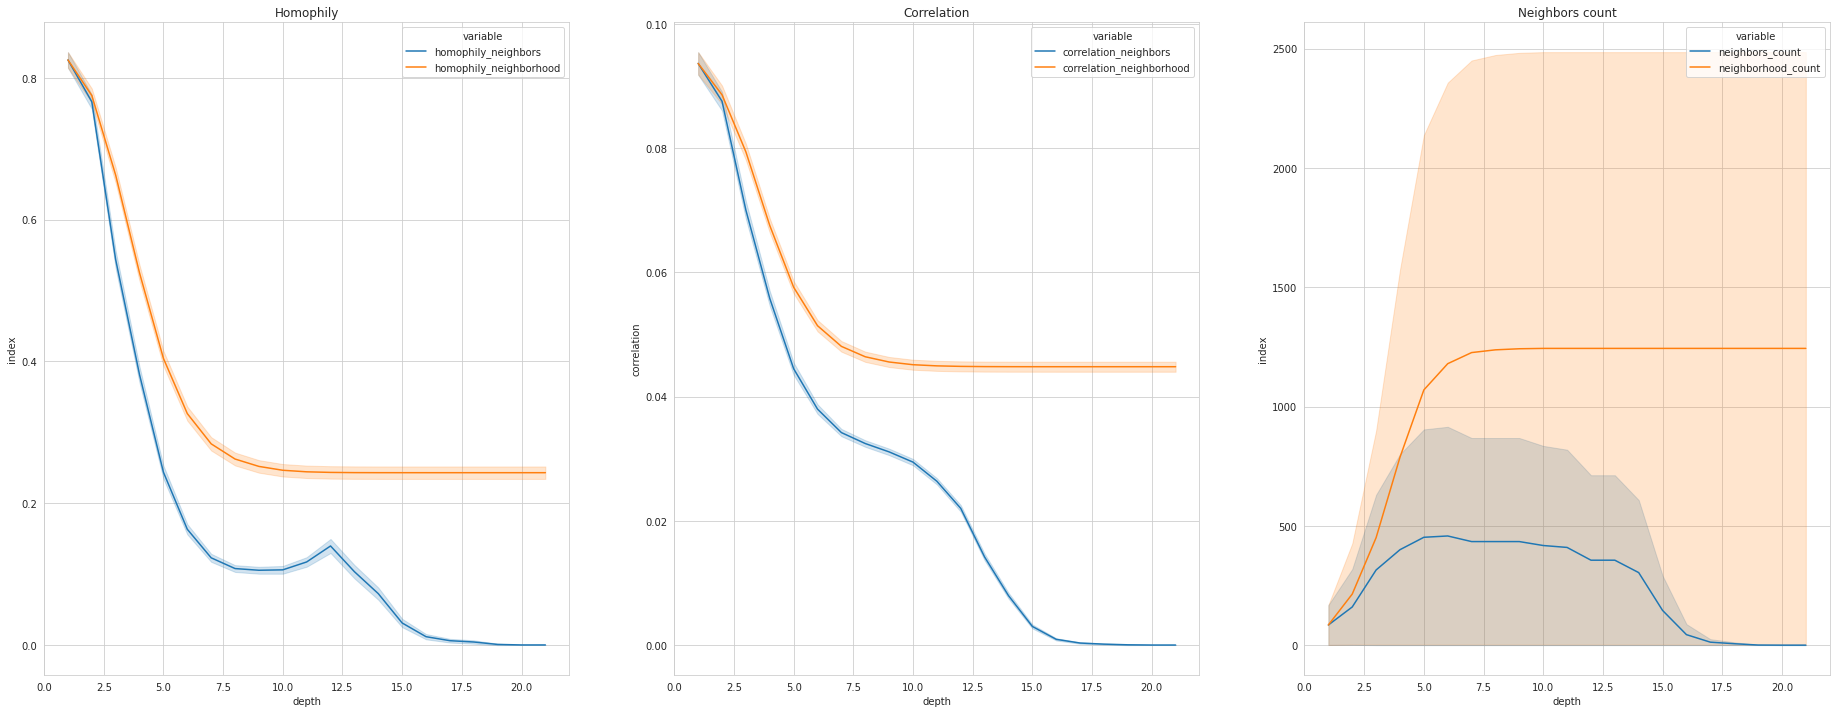

In [ ]:
cora_summary = graph_summary(cora_dataset, optim="gpu", K=20)

In [ ]:
cora_summary.to_csv("./cora_summary.csv")
files.download('./cora_summary.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **📰 Citeseer**

In [ ]:
citeseer = load_dataset(path, "CiteSeer")

Processing...
Done!


  0%|          | 0/35 [00:00<?, ?it/s]

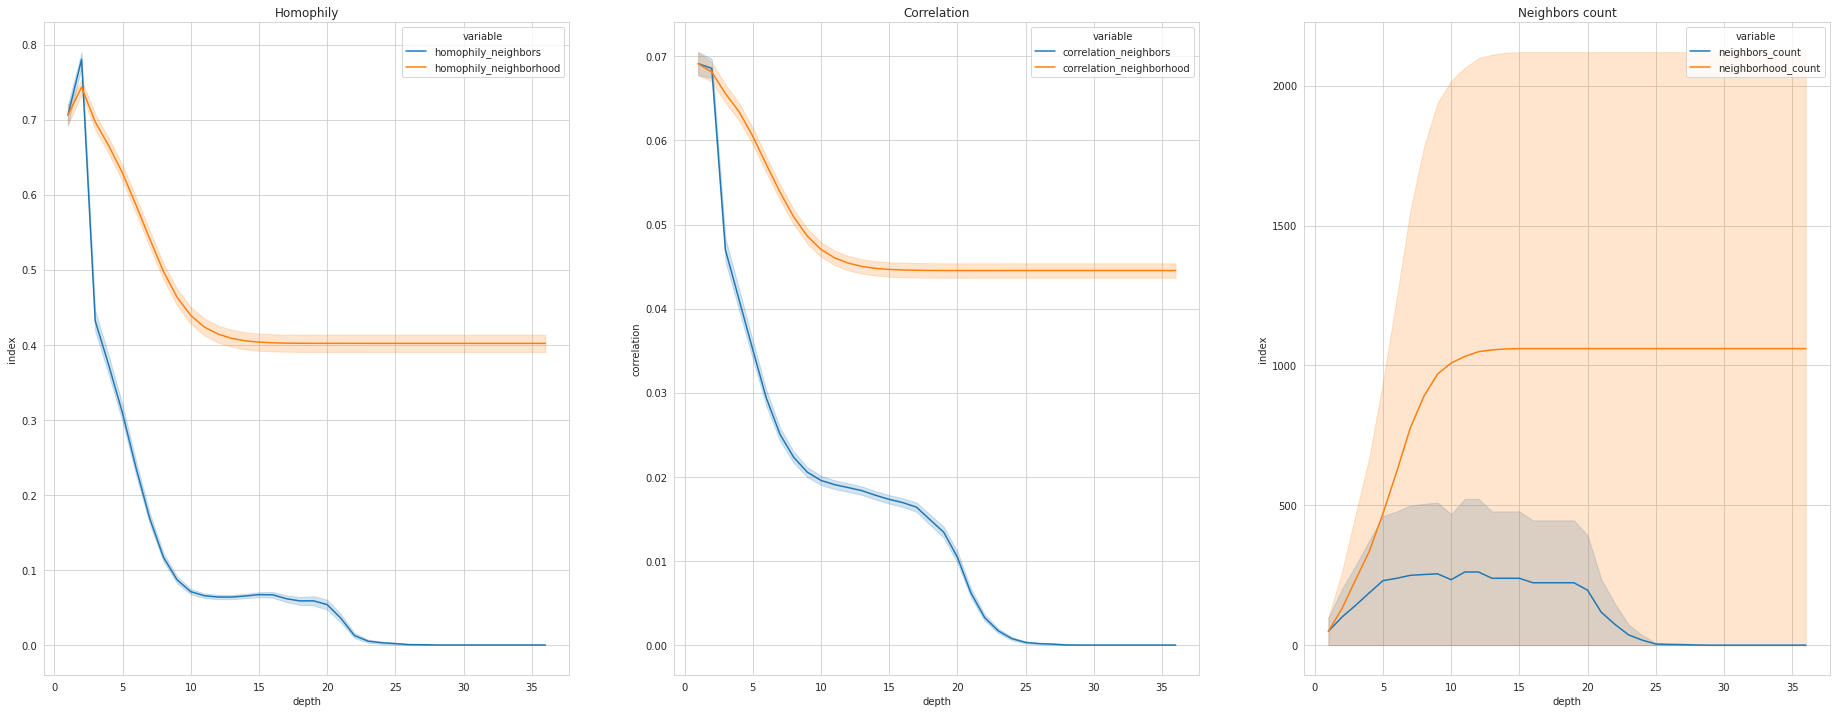

In [ ]:
citeseer_summary = graph_summary(citeseer, optim="gpu", K=35)

In [ ]:
citeseer_summary.to_csv("./citeseer_summary.csv")
files.download('./citeseer_summary.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **📦 Amazon Photo (short-range)**

In [ ]:
amazon = load_dataset(path, 'Amazon', params=dict(goods="Photo"))

Processing...
Done!


  0%|          | 0/10 [00:00<?, ?it/s]

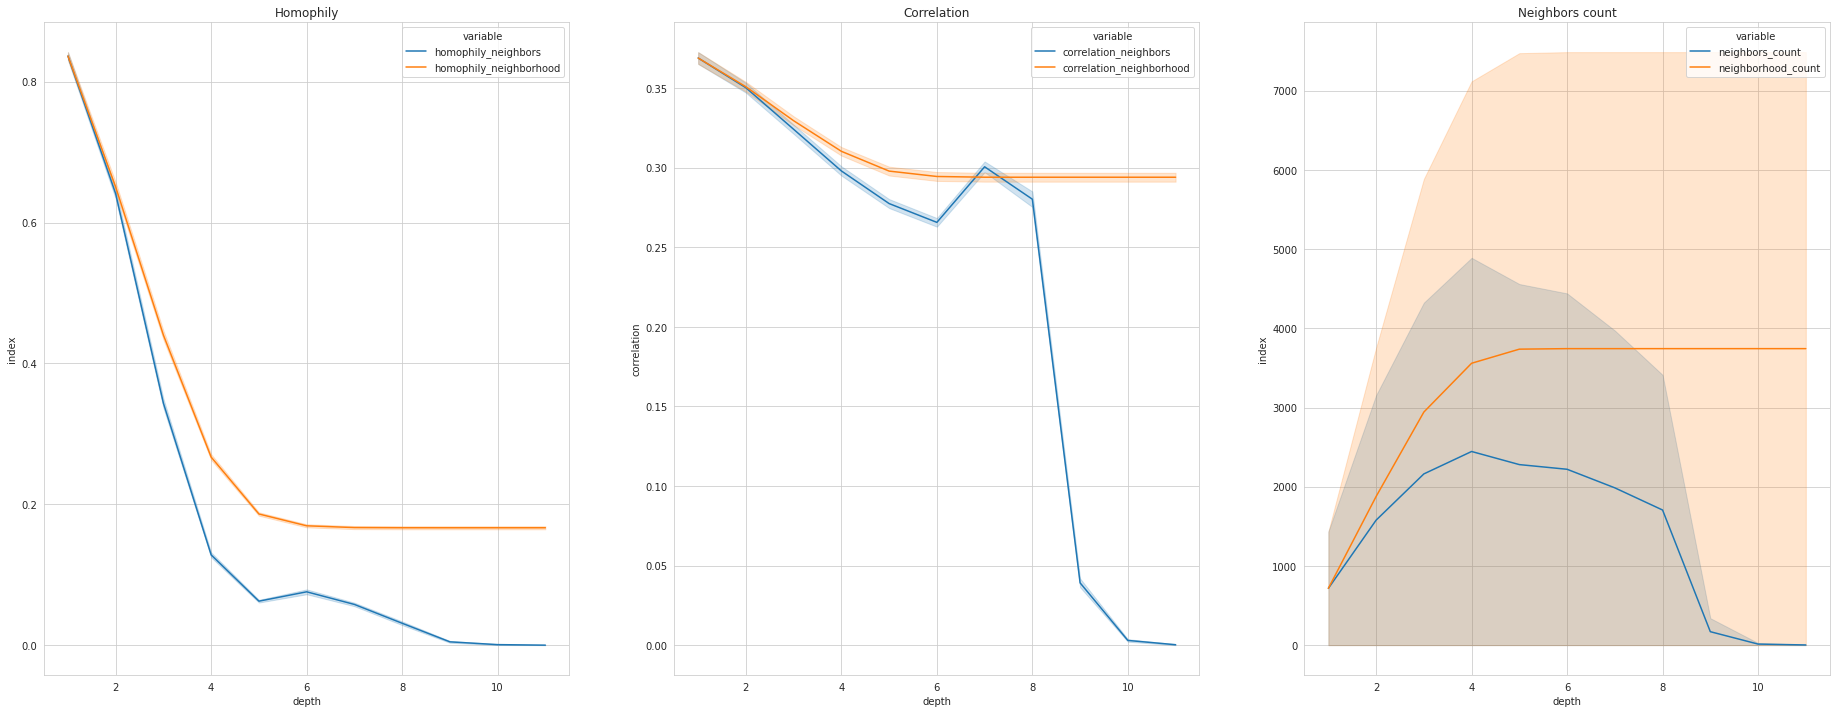

In [ ]:
amazon_summary = graph_summary(amazon, optim='gpu')

In [ ]:
amazon_summary.to_csv("./amazon_summary.csv")
files.download('./amazon_summary.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **📦 Amazon Computers (short-range)**

In [ ]:
amazon = load_dataset(path, 'Amazon', params=dict(goods="Computers"))

Processing...
Done!


In [ ]:
amazon_summary = graph_summary(amazon, optim='gpu', K=15)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
amazon_summary.to_csv("./amazon_summary_computers.csv")
files.download('./amazon_summary_computers.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

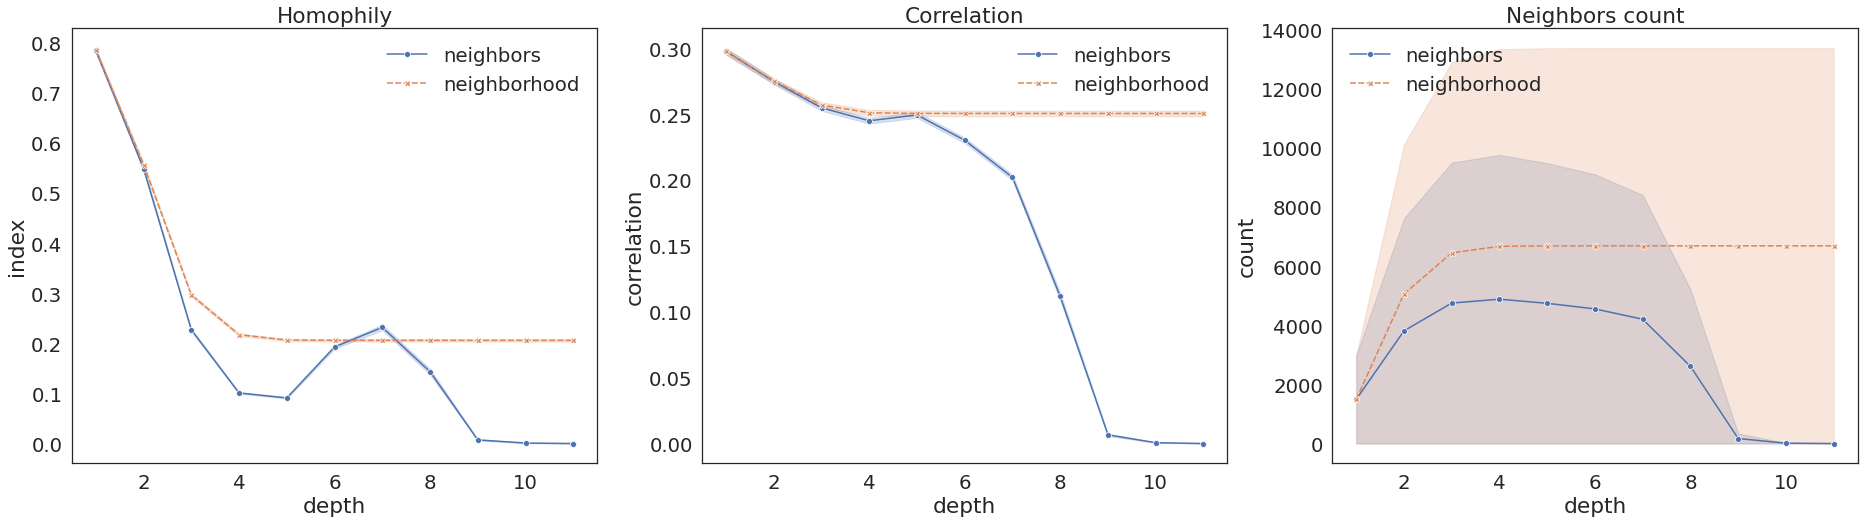

In [ ]:
plot_summary(amazon_summary)

### **📰 PubMed (big graph)**

In [12]:
%%capture
pubmed = load_dataset(path, "PubMed")

In [13]:
pubmed_summary = graph_summary(pubmed, K=20, optim="memory")

  0%|          | 0/20 [00:00<?, ?it/s]

In [14]:
pubmed_summary.to_csv("./pubmed_summary.csv", index=False)
files.download('./pubmed_summary.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

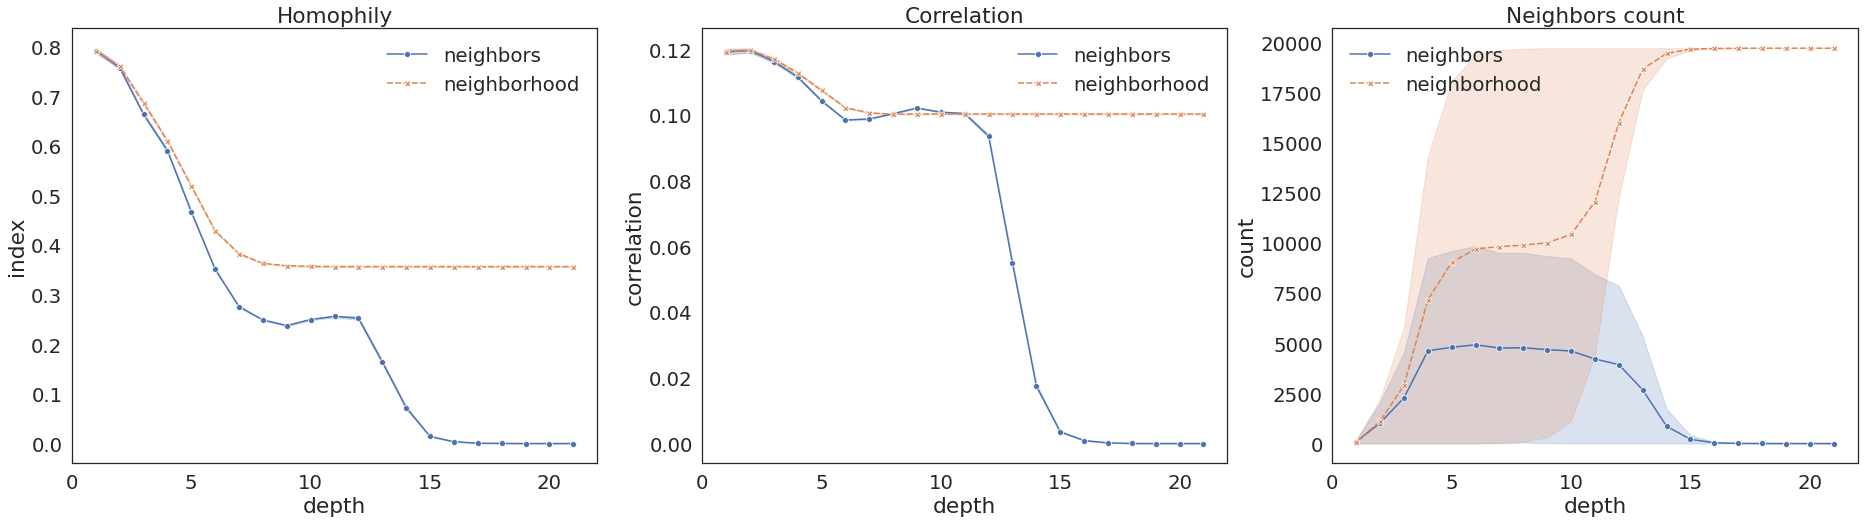

In [15]:
plot_summary(pubmed_summary)

### **📰 Ogbn-Arxiv**

In [ ]:
%%capture
!pip install ogb

In [ ]:
from torch_geometric.transforms import ToSparseTensor
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

dataset = PygNodePropPredDataset(name='ogbn-arxiv',
                                 transform=ToSparseTensor())

data = dataset[0]
data.edge_index = data.adj_t
# data.dense_adj = data.adj_t.to_symmetric().to_dense()

  0%|          | 0/81 [00:00<?, ?it/s]

Downloaded 0.08 GB: 100%|██████████| 81/81 [00:03<00:00, 22.22it/s]


Extracting dataset/arxiv.zip
Processing...
Loading necessary files...
This might take a while.


100%|██████████| 1/1 [00:00<00:00, 287.18it/s]

Processing graphs...
Converting graphs into PyG objects...
Saving...


Done!


In [ ]:
graph_summary(data)

##### Not relevant in this notebook

In [ ]:
# evaluator = Evaluator(name='ogbn-arxiv')
# @torch.no_grad()
# def test(model, data, split_idx, evaluator):
#     model.eval()

#     out = model(data.x, data.adj_t)
#     y_pred = out.argmax(dim=-1, keepdim=True)

#     train_acc = evaluator.eval({
#         'y_true': data.y[split_idx['train']],
#         'y_pred': y_pred[split_idx['train']],
#     })['acc']
#     valid_acc = evaluator.eval({
#         'y_true': data.y[split_idx['valid']],
#         'y_pred': y_pred[split_idx['valid']],
#     })['acc']
#     test_acc = evaluator.eval({
#         'y_true': data.y[split_idx['test']],
#         'y_pred': y_pred[split_idx['test']],
#     })['acc']

#     return train_acc, valid_acc, test_acc